#DistArray: Distributed Arrays for Python

Example: Scaling behavior of Gaussian Elimination (L-U decomposition)
-----------------------------------------------------------------

In [1]:
# utility imports
from __future__ import print_function
from pprint import pprint
from matplotlib import pyplot as plt

# main imports
import numpy as np
import distarray.globalapi as da
from distarray.plotting import plot_array_distribution

# output goodness
np.set_printoptions(precision=2)

# display figures inline
%matplotlib inline

Before anything else, we must define the parameter space for our study. We will examine the scaling performance of the algorithm by perturbing the **distribution type** and the **matrix size**:

In [2]:
distributions = (('n','b','c'), ('n','b','c'))
sizes = [8]

Next, we create a context and devise a scheme for generating some synthetic data (in this case a matrix) on which to operate:

In [3]:
context = da.Context()

In [4]:
def synthetic_data_generator(contextobj, datashape=(16, 16), distscheme=('b', 'n')):
    distribution = da.Distribution(contextobj, shape=datashape, dist=distscheme)
    _syndata = np.random.random(datashape)
    syndata = contextobj.fromarray(_syndata, distribution=distribution)
    return syndata

In order for the Gaussian Elimination operation to be truly parallel, we need to define a uFunc to perform the desired computation:

In [5]:
def parallel_gauss_elim(datashape, darray, pivot_row, k, m):
    """
    Function to perform gauss elimination (w/o scaling) locally on all engines.
    datashape: shape of global distributed array
    darray: handle to the distributed array
    pivot_row: numpy array containing global pivot row
    k: pivot index
    m: vector containing pivoting factors for all rows globally
    """
    
    import numpy as np
    
    # retrieve local indices for submatrix that needs to be operated on
    n_rows, n_cols = datashape    
    i_slice, j_slice = darray.distribution.local_from_global((slice(k+1, n_rows), 
                                                              slice(k, n_cols)))
    
    # limit the slices using actual size of local array
    n_rows_local, n_cols_local = darray.ndarray.shape
    i_indices, j_indices = (i_slice.indices(n_rows_local), 
                            j_slice.indices(n_cols_local))
    
    # determine which elements of global pivot row correspond to local entries
    _, piv_slice = darray.distribution.global_from_local((slice(0, n_rows_local), 
                                                          slice(*j_indices)))
    piv_indices = piv_slice.indices(n_cols)
    
    # determine which elements of global pivot factor vector corresponds to local
    mul_slice, _ = darray.distribution.global_from_local((slice(*i_indices), 
                                                          slice(0, n_cols_local)))
    mul_indices = mul_slice.indices(n_rows)
    
    # perform the elimination to create zeros below pivot
    if (i_indices[0] == i_indices[1] or j_indices[0] == j_indices[1]):
        # computation for this local block is done
        pass
    else:
        for i, mul in zip(xrange(*i_indices), xrange(*mul_indices)):
            np.subtract(darray.ndarray[i, slice(*j_indices)], 
                        np.multiply(m[mul], pivot_row[slice(*piv_indices)]),
                        out=darray.ndarray[i, slice(*j_indices)])
        pass
            
    
context.register(parallel_gauss_elim)

Now, define the high level function that runs on the client and manages the GE operation. Using this function is a way of ensuring synchronicity between the many engines performing this operation. After a pivot row is determined, it is broadcast along with a vector of pivoting factors to the worker engines via the `parallel_gauss_elim` uFunc. 

In [6]:
def execute_ge(contextobj, darray):
    N = min(darray.shape)
    for k in range(N-1):
        print (k)
        pivot_factors = (d_array[:, k]/d_array[k, k]).toarray()
        contextobj.parallel_gauss_elim(darray.shape, darray, darray[k, :].toarray(), k, pivot_factors)

We now write the code which is executed on the client to setup a matrix, track and broadcast the pivot elements as they change, and synchronize communication between all the engines:

0
1
2
3
4
5
6


<DistArray(shape=(8, 8), targets=[0, 1, 2, 3])>

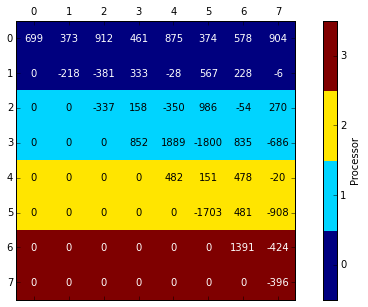

In [7]:
N = sizes[0]
d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=('b','n'))
execute_ge(context, d_array)
process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
plot_array_distribution(d_array, process_coords, legend=True)

0
1
2
3
4
5
6


<DistArray(shape=(8, 8), targets=[0, 1, 2, 3])>

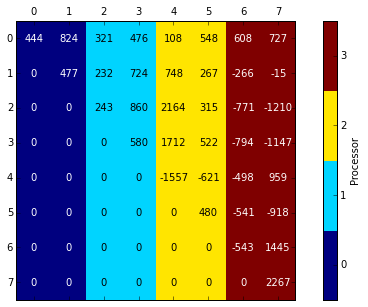

In [8]:
d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=('n','b'))
execute_ge(context, d_array)
d_array.toarray()
process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
plot_array_distribution(d_array, process_coords, legend=True)

0
1
2
3
4
5
6


<DistArray(shape=(8, 8), targets=[0, 1, 2, 3])>

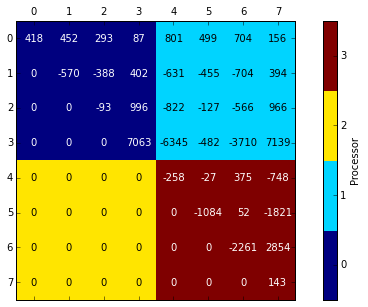

In [9]:
d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=('b','b'))
execute_ge(context, d_array)
d_array.toarray()
process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
plot_array_distribution(d_array, process_coords, legend=True)

[[ 499.39  410.4   356.43  802.72  890.45  306.71  466.06  282.92]
 [ 460.06  286.31  715.    783.94  391.46  672.43  211.3   214.06]
 [ 445.04  347.81  815.69  789.97  811.03   26.48  213.94  612.12]
 [ 355.59  233.66  291.46   61.79  892.54  635.86  545.05  236.01]
 [ 120.88  722.72  102.22  377.75  787.98  601.79  708.     97.08]
 [ 258.87   69.7   668.99  426.84  200.57  230.56   98.2   263.86]
 [ 152.06  298.26  803.34  141.02  656.18  164.24  935.46   89.88]
 [ 890.68  804.71  396.04   87.29  865.63  871.95  709.37  463.31]]


<DistArray(shape=(8, 8), targets=[0, 1, 2, 3])>

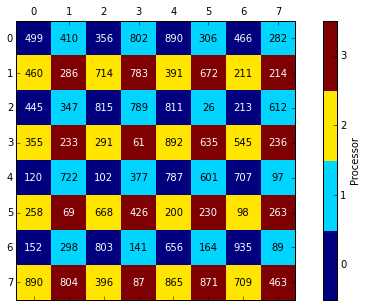

In [14]:
d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=('c','c'))
print (d_array.toarray())
process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
plot_array_distribution(d_array, process_coords, legend=True)

In [11]:
d_array.localshapes()

[(2, 8), (2, 8), (2, 8), (2, 8)]

In [17]:
d_array[:1,:1]

AttributeError: 'BlockCyclicMap' object has no attribute 'slice_owners'